In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras
import argparse
from imutils import paths
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

In [38]:
imagepath = list(paths.list_images('./dataset'))

In [39]:
data = []
labels =[]

In [40]:
for imagepat in imagepath:
    label = imagepat.split(os.path.sep)[-2]
    image = load_img(imagepat,target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)


In [41]:
data = np.array(data,dtype="float32")    
labels = np.array(labels)

In [42]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [44]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [45]:
from sklearn.model_selection import train_test_split


In [50]:
(X_train,X_test,y_train,y_test) = train_test_split(data,labels,test_size=0.20,random_state=42,stratify=labels)

In [53]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
aug = ImageDataGenerator(
                 rotation_range=20,
                 zoom_range=0.15,
                 width_shift_range=0.2,
                 height_shift_range=0.2,
                 shear_range=0.15,
                 horizontal_flip=True,
                 fill_mode='nearest'
                 )

In [56]:
from tensorflow.keras.applications import MobileNetV2

In [60]:
base_model = MobileNetV2(weights='imagenet',include_top=False,input_tensor=tf.keras.layers.Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 9s 1us/step


In [62]:
head_model = base_model.output
head_model = tf.keras.layers.AveragePooling2D(pool_size=(7,7))(head_model)
head_model = tf.keras.layers.Flatten()(head_model)
head_model = tf.keras.layers.Dense(128,activation='relu')(head_model)
head_model = tf.keras.layers.Dense(63,activation='relu')(head_model)
head_model = tf.keras.layers.Dropout(0.5)(head_model)
head_model = tf.keras.layers.Dense(2,activation='softmax')(head_model)

In [63]:
model = tf.keras.Model(inputs=base_model.input,outputs=head_model)

In [64]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [65]:
for layer in base_model.layers:
    layer.trainable = False

In [66]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=1e-4),metrics=['accuracy'])

In [67]:
history = model.fit(aug.flow(X_train,y_train,batch_size=32),steps_per_epoch=32,validation_data=(X_test,y_test),epochs=20)

Epoch 1/20
32/32 [==============================] - 49s 2s/step - loss: 0.5417 - accuracy: 0.7510 - val_loss: 0.1911 - val_accuracy: 0.9746
Epoch 2/20
32/32 [==============================] - 47s 1s/step - loss: 0.2050 - accuracy: 0.9233 - val_loss: 0.0720 - val_accuracy: 0.9928
Epoch 3/20
32/32 [==============================] - 47s 1s/step - loss: 0.1258 - accuracy: 0.9602 - val_loss: 0.0443 - val_accuracy: 0.9964
Epoch 4/20
32/32 [==============================] - 48s 1s/step - loss: 0.0784 - accuracy: 0.9771 - val_loss: 0.0292 - val_accuracy: 0.9964
Epoch 5/20
32/32 [==============================] - 48s 1s/step - loss: 0.0644 - accuracy: 0.9821 - val_loss: 0.0240 - val_accuracy: 0.9891
Epoch 6/20
32/32 [==============================] - 47s 1s/step - loss: 0.0522 - accuracy: 0.9871 - val_loss: 0.0204 - val_accuracy: 0.9928
Epoch 7/20
32/32 [==============================] - 47s 1s/step - loss: 0.0369 - accuracy: 0.9940 - val_loss: 0.0186 - val_accuracy: 0.9928
Epoch 8/20
32/32 [==

In [68]:
predict = model.predict(X_test,batch_size=32)

In [69]:
predict = np.argmax(predict,axis=1)

In [80]:
from sklearn.metrics import classification_report


In [84]:
print(classification_report(y_test.argmax(axis=1),predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       138
           1       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [85]:
model.save('./my_mask_detector.h5') 

In [86]:
model.save('./my_second_mask',save_format='h5')#2 different methods of saving 

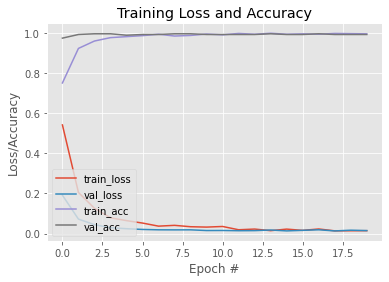

In [89]:
import matplotlib.pyplot as plt
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('./plot1.png')